Notebook for testing the TETRAQUAD module

In [12]:
import tetraquad
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.001
N = 50

#grid, weights = tetraquad.old2_unit_quadrature(alpha, N)
grid, weights = tetraquad.unit_quadrature_nnls(alpha, N)
weights = weights.flatten()

#grid2, weights2 = tetraquad.uniform_tetrapyd_weights(alpha, N)

#np.save("grid_N10.npy", grid)
#np.save("weights_N10.npy", weights)

M = 70 , N = 50
11022 11375


In [13]:
#np.save("grid_N50_nnlm.npy", grid)
#np.save("weights_N50_nnlm.npy", weights)

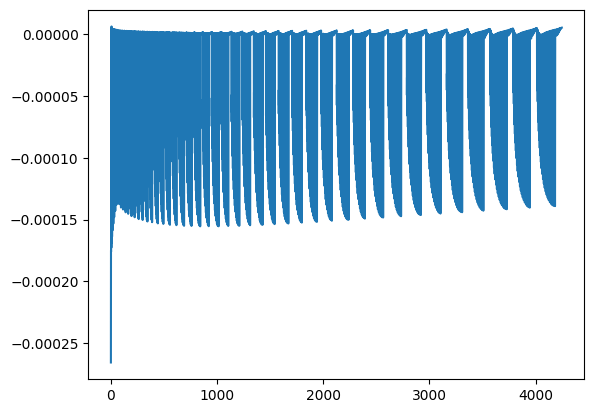

In [22]:
# Test to check numerical integration accuracy

k1, k2, k3 = grid
ps, qs, rs = tetraquad.poly_triplets_total_degree(N)
ps = ps + 0.5
qs = qs + 0.5
rs = rs + 0.5

analytic = tetraquad.analytic_poly_integrals(ps, qs, rs, alpha)
numerical = np.array([np.dot(weights, tetraquad.poly_evaluations(p, q, r, k1, k2, k3)) for p, q, r in zip(ps, qs, rs)])
#numerical2 = np.array([np.dot(weights2, tetraquad.poly_evaluations(p, q, r, grid2[0,:], grid2[1,:], grid2[2,:])) for p, q, r in zip(ps, qs, rs)])

error = (numerical - analytic) / analytic
#error2 = (numerical2 - analytic) / analytic
plt.plot(error)

0.7251572668368016


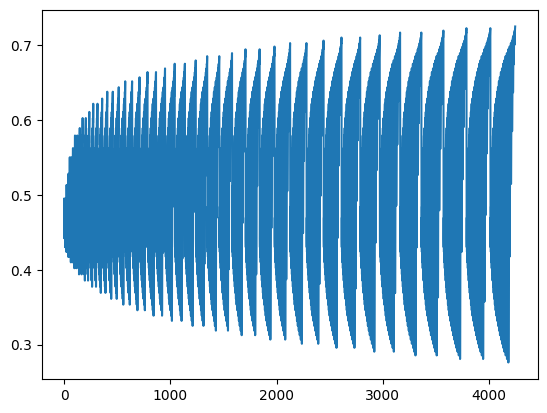

In [19]:
t1 = tetraquad.analytic_poly_integrals(- 0.96 * np.ones_like(ps), qs, rs, alpha)
tn1 = np.array([np.dot(weights, tetraquad.poly_evaluations(-0.96, q, r, k1, k2, k3)) for q, r in zip(qs, rs)])

e1 = (tn1 - t1) / t1
print(np.max(np.abs(e1)))
plt.plot(e1)

5.237888697068019e-06


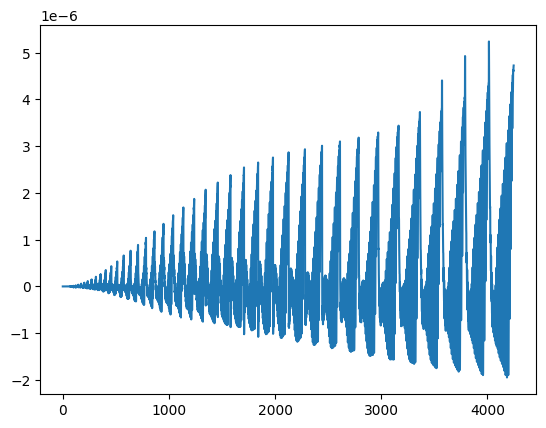

In [17]:
#plt.plot(analytic)
#plt.plot(numeric)
#plt.plot(analytic/numeric)
plt.plot(error)
#plt.plot(error2, 'r')
print(np.max(np.abs(error)))
#print(np.max(np.abs(error2)))
#plt.xlim([0,10])
#print(error[0], error2[0])
#plt.plot((analytic/numeric)[:67])
#print((analytic/numeric)[:67])

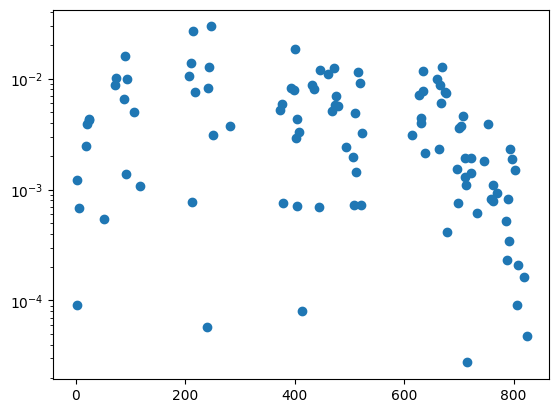

In [12]:
plt.plot(weights, "o")
plt.yscale("log")

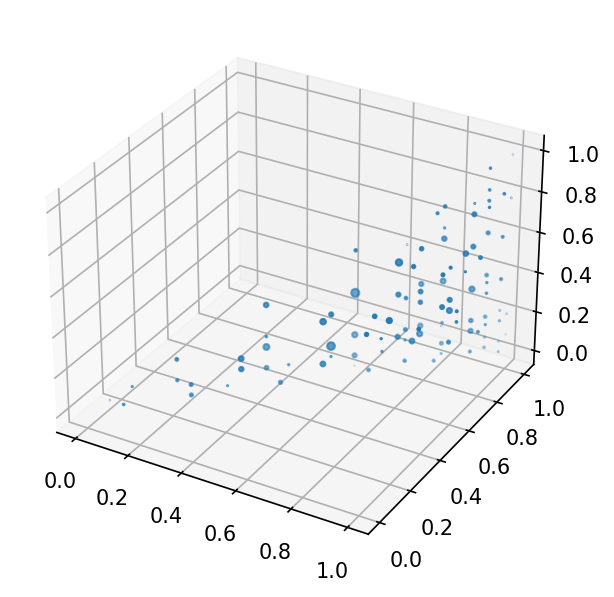

In [9]:
%matplotlib inline
s = weights * 500
xs, ys, zs = grid
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs, ys, zs, s=s)
plt.show()

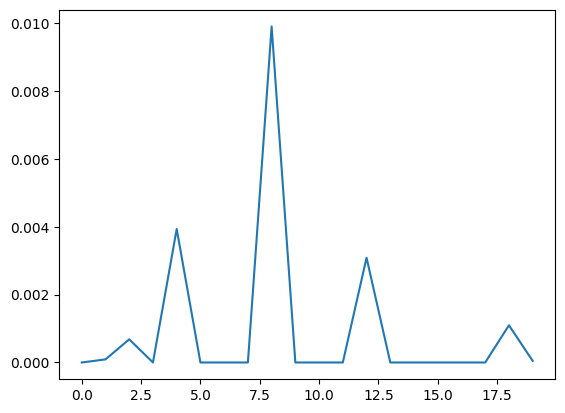

In [7]:
plt.plot(weights[(xs == ys) & (ys == zs)])

(array([733.,   4.,  12.,   4.,   5.,   2.,   5.,   3.,   2.,   1.,   2.,
          2.,   3.,   3.,   4.,   1.,   2.,   2.,   0.,   2.,   2.,   0.,
          1.,   2.,   0.,   3.,   2.,   3.,   0.,   3.,   1.,   0.,   0.,
          2.,   1.,   0.,   1.,   1.,   1.,   0.,   2.,   0.,   2.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.        , 0.00029573, 0.00059145, 0.00088718, 0.0011829 ,
        0.00147863, 0.00177436, 0.00207008, 0.00236581, 0.00266154,
        0.00295726, 0.00325299, 0.00354871, 0.00384444, 0.00414017,
        0.00443589, 0.00473162, 0.00502734, 0.00532307, 0.0056188 ,
        0.00591452, 0.00621025, 0.00650597, 0.

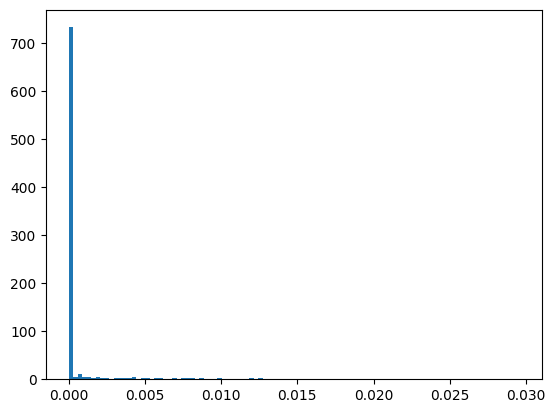

In [9]:
#weights.flatten()
plt.hist(weights, bins=100)